In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical

In [2]:
# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Data I/O
data = open('input.txt', 'r').read()  # This should be a simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [3]:
# Hyperparameters
hidden_size = 100  # Size of hidden layer of neurons
seq_len = 25  # Number of steps to unroll the RNN for
learning_rate = 1e-1
epochs = 20
save_path = 'model.pth'
op_seq_len = 200  # Length of the output sequence
num_layers = 3

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
import os

# Remove incompatible cuDNN versions from LD_LIBRARY_PATH
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ['LD_LIBRARY_PATH']


In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.decoder(output)
        return output, hidden_state

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size).to(device),
                torch.zeros(self.num_layers, 1, self.hidden_size).to(device))

# Instantiate model, loss function and optimizer
rnn = RNN(vocab_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

In [8]:
# Convert a sequence of characters to a tensor
def char_tensor(seq):
    tensor = torch.tensor([char_to_ix[ch] for ch in seq], dtype=torch.long).unsqueeze(0).to(device)
    return tensor

In [9]:
losses = []
epochs_cnt = []

In [10]:
# Training loop
for i_epoch in range(1, epochs + 1):
    # Random starting point (1st 100 chars) from data to begin
    data_ptr = np.random.randint(100)
    n = 0
    running_loss = 0
    hidden_state = rnn.initHidden()

    while True:
        input_seq = char_tensor(data[data_ptr : data_ptr + seq_len])
        target_seq = char_tensor(data[data_ptr + 1 : data_ptr + seq_len + 1])

        # Forward pass
        output, hidden_state = rnn(input_seq, hidden_state)
        output = output.view(-1, vocab_size)
        target_seq = target_seq.view(-1)

        # Compute loss
        loss = criterion(output, target_seq)
        running_loss += loss.item()

        # Compute gradients and take optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Detach hidden state to prevent backprop through entire training history
        hidden_state = (hidden_state[0].detach(), hidden_state[1].detach())

        # Update the data pointer
        data_ptr += seq_len
        n += 1

        # If at end of data, break
        if data_ptr + seq_len + 1 > data_size:
            break

    # Print loss and save weights after every epoch
    print("Epoch: {0} \t Loss: {1:.8f}".format(i_epoch, running_loss / n))
    epochs_cnt.append(i_epoch)
    losses.append(running_loss / n);
    torch.save(rnn.state_dict(), save_path)

    # Sample / generate a text sequence after every epoch
    data_ptr = 0
    hidden_state = rnn.initHidden()

    # Random character from data to begin
    rand_index = np.random.randint(data_size - 1)
    input_seq = char_tensor(data[rand_index : rand_index + 1])

    print("----------------------------------------")
    while True:
        # Forward pass
        output, hidden_state = rnn(input_seq, hidden_state)

        # Construct categorical distribution and sample a character
        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample()

        # Print the sampled character
        print(ix_to_char[index.item()], end='')

        # Next input is current output
        input_seq = char_tensor(ix_to_char[index.item()])
        data_ptr += 1

        if data_ptr > op_seq_len:
            break

    print("\n----------------------------------------")


Epoch: 1 	 Loss: 3.97747574
----------------------------------------
been nOnTTOOnoedhh oiwh.tatk.lgoegah El  Ihs iTOTO T ThOoon oWhTtyegeTlilw boinEnghhEgylaTnnTs eginhET T,ooTl.OoTatdwetsgyaBnTT Tn ' lno..ishskwaat stnnOlwhato.nTbOgETyT.shnsneWit ;OgnwA agnnBghahtOnoT
----------------------------------------
Epoch: 2 	 Loss: 3.97823547
----------------------------------------
TneBoboOOgga'e'Wal TW nOT OleswwraaihheeTegllyWs  .rli.  . OaTOOOkeSm.TlsOnalel.ywa peegT;aEeawilIhl abaeenesOgrOO wn.ya.It t.naTO O .lawTgkIOkrpr OiWw 'Tw  lOrl, snaOgsrW  'aeTlmlOWeOOTstOmElrOgO  aoe
----------------------------------------
Epoch: 3 	 Loss: 3.69692694
----------------------------------------

u ubYYYY,;;;;Y,;;;YY;Yb;Y;; YY;Y;;;,YYYl;;;Y;;,YYY'YYYY;;Y;;;Y;Y;YYYYYYY;Y;;YYYY;,;YYYYY;;YYYY;YY;YY;YY;Y;;Y;;;,;;;;;YYYY;Y;;YYYYY,Y;;YE;YYYY;YY,Y;;;Y;YYYYY;kYZYY;,YY;;Y,YY;;YYY;Y;Y;YY;;;YY'YY;YYYY;YY
----------------------------------------
Epoch: 4 	 Loss: 3.73232539
------------------------------------

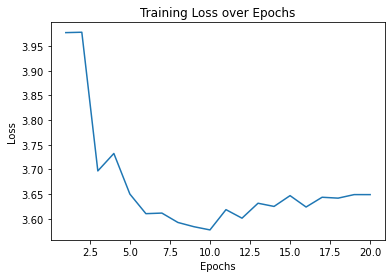

In [11]:
from matplotlib import pyplot as plt
plt.plot(epochs_cnt, losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Data I/O
data = open('input.txt', 'r').read()  # This should be a simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Hyperparameters
hidden_size = 100  # Size of hidden layer of neurons
seq_len = 25  # Number of steps to unroll the RNN for
learning_rate = 1e-1
epochs = 20
save_path = 'model.pth'
op_seq_len = 200  # Length of the output sequence
num_layers = 1

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ResidualLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(ResidualLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)  # Change embedding size to match hidden size
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        residual = embedding.clone()  # Use clone to avoid in-place operations
        output, hidden_state = self.lstm(embedding, hidden_state)
        output = output + residual  # Add residual connection
        output = self.decoder(output)
        return output, hidden_state

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size).to(device),
                torch.zeros(self.num_layers, 1, self.hidden_size).to(device))

# Instantiate model, loss function and optimizer
rnn = ResidualLSTM(vocab_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

# Convert a sequence of characters to a tensor
def char_tensor(seq):
    tensor = torch.tensor([char_to_ix[ch] for ch in seq], dtype=torch.long).unsqueeze(0).to(device)
    return tensor

losses = []
epochs_cnt = []

# Training loop
for i_epoch in range(1, epochs + 1):
    # Random starting point (1st 100 chars) from data to begin
    data_ptr = np.random.randint(100)
    n = 0
    running_loss = 0
    hidden_state = rnn.initHidden()

    while True:
        input_seq = char_tensor(data[data_ptr : data_ptr + seq_len])
        target_seq = char_tensor(data[data_ptr + 1 : data_ptr + seq_len + 1])

        # Forward pass
        output, hidden_state = rnn(input_seq, hidden_state)
        output = output.view(-1, vocab_size)
        target_seq = target_seq.view(-1)

        # Compute loss
        loss = criterion(output, target_seq)
        running_loss += loss.item()

        # Compute gradients and take optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Detach hidden state to prevent backprop through entire training history
        hidden_state = (hidden_state[0].detach(), hidden_state[1].detach())

        # Update the data pointer
        data_ptr += seq_len
        n += 1

        # If at end of data, break
        if data_ptr + seq_len + 1 > data_size:
            break

    # Print loss and save weights after every epoch
    print("Epoch: {0} \t Loss: {1:.8f}".format(i_epoch, running_loss / n))
    epochs_cnt.append(i_epoch)
    losses.append(running_loss / n)
    torch.save(rnn.state_dict(), save_path)

    # Sample / generate a text sequence after every epoch
    data_ptr = 0
    hidden_state = rnn.initHidden()

    # Random character from data to begin
    rand_index = np.random.randint(data_size - 1)
    input_seq = char_tensor(data[rand_index : rand_index + 1])

    print("----------------------------------------")
    while True:
        # Forward pass
        output, hidden_state = rnn(input_seq, hidden_state)

        # Construct categorical distribution and sample a character
        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample()

        # Print the sampled character
        print(ix_to_char[index.item()], end='')

        # Next input is current output
        input_seq = char_tensor(ix_to_char[index.item()])
        data_ptr += 1

        if data_ptr > op_seq_len:
            break

    print("\n----------------------------------------")

from matplotlib import pyplot as plt
plt.plot(epochs_cnt, losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()


data has 1115394 characters, 65 unique.
Epoch: 1 	 Loss: 13.76079744
----------------------------------------
e sleee whinge rasle rt'tre rasletre ingee rasleeee ralee rasleeee thon; sle inge re sle sle rasleeee sle maslee re inge thyee uasleee sle olet sle rasleeeee sle occcccccccccccccccccccccccccccccccccccc
----------------------------------------
Epoch: 2 	 Loss: 16.47507999
----------------------------------------
 sle, uandsle, tee, t tre, tr tr uandsle, tr tr ouandsle, th'sle, tr t aeb
N:
ON:
NIAN:
Th'sle sle, tr tr sle, tee, te, tee, spe, tre, tr thyeble, tr uandseble, t, windsleee, seble, tar tr t uandsle, t
----------------------------------------
Epoch: 3 	 Loss: 17.69790749
----------------------------------------
SEBu rebandeban.

SEBu lebandeban.

SEBu deban.

SEBu deban.

SEBu deblebandeban.

SEBur deeeban.

SEBu deblebandebandebandebandeban.

SEBu deban.

SEBu deblebaneban.

SEBu debaneban.

SEBu deban.

SEB
----------------------------------------
Epoch: 4 	 Loss: 18.2

KeyboardInterrupt: 